In [1]:
from numpy.linalg import svd, norm
from scipy.optimize import minimize, NonlinearConstraint
from scipy.optimize import differential_evolution
from tqdm import tqdm 


In [2]:
import numpy as np
from scipy.stats import ortho_group, unitary_group
import matplotlib.pyplot as plt
from scipy.linalg import schur, eigvals
from scipy.linalg import block_diag
from numpy import linalg as LA
import math
import time

In [3]:
from numpy import linalg
from scipy.linalg import block_diag
from scipy.spatial.transform import Rotation as R
from module.unitary_dilation import dilation, check_if_can_dilate
from scipy.linalg import sqrtm


In [4]:
from module._rc_operations import cycle
from module.util import check_orthogonal, spec_radius, rot_angles
from module.orthogonal_equiv import ortho_xform
from module.perfect_match_graph import approximateTu

In [5]:
ndim_max_times = 6
ndim_min = 10

randomize_num = 5

In [6]:
ndim_list = np.linspace(ndim_min, ndim_max_times * ndim_min, num=ndim_max_times, dtype=int)

In [7]:
Full_n1_list = []
Full_cdim_list = []

In [8]:
for ndim in tqdm(ndim_list):
    print(ndim)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 101885.93it/s]

10
20
30
40
50
60


In [9]:
for ndim in tqdm(ndim_list):
    
    local_n1 = np.zeros(randomize_num)
    local_cdim = np.zeros(randomize_num)
    
    for k in range(randomize_num):

        U = ortho_group.rvs(ndim)

        Tu, Ju = schur(U/spec_radius(U), output = 'real')

        T_approx = approximateTu(Tu/spec_radius(Tu), epsilon = 0.01, n1_flag = True)

        if T_approx[1].shape[0] > 0:
            T_full = block_diag(*[T_approx[0], T_approx[1]])
        else:
            T_full = T_approx[0]

        dim_cyc = T_full.shape[0]
        C = cycle(dim_cyc, spectral_radius = 1)

        Tc, Jc = schur(C, output='real')
        assert np.allclose(Jc @ Tc @ Jc.T, C)

        #A_values, A_vectors = np.linalg.eig(Ta)
        #C_values, C_vectors = np.linalg.eig(Tc)

        #assert np.allclose(np.sort(A_values), np.sort(C_values))

        # Find orthogonal transform:
        P_bar = ortho_xform(T_full,Tc)

        #         print('P orthogonal?')
        assert check_orthogonal(Jc)
        assert check_orthogonal(P_bar)
        assert np.allclose(P_bar @ T_full @ P_bar.T, Tc)
        
        local_n1[k] = T_approx[-1]
        local_cdim[k] = C.shape[0]
    
    Full_n1_list.append(local_n1)
    Full_cdim_list.append(local_cdim)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:27<00:00,  4.61s/it]


In [10]:
local_n1

array([38328., 38328., 38328., 38328., 38328.])

In [11]:
Full_n1_list

[array([6912., 6912., 6912., 6912., 6912.]),
 array([13195., 13195., 13195., 13195., 13195.]),
 array([19478., 19478., 19478., 19478., 19478.]),
 array([25761., 25761., 25761., 25761., 25761.]),
 array([32045., 32045., 32045., 32045., 32045.]),
 array([38328., 38328., 38328., 38328., 38328.])]

In [12]:
Full_n1_list = np.array(Full_n1_list)

In [13]:
np.array(Full_n1_list).shape

(6, 5)

In [16]:
sem

array([0., 0., 0., 0., 0., 0.])

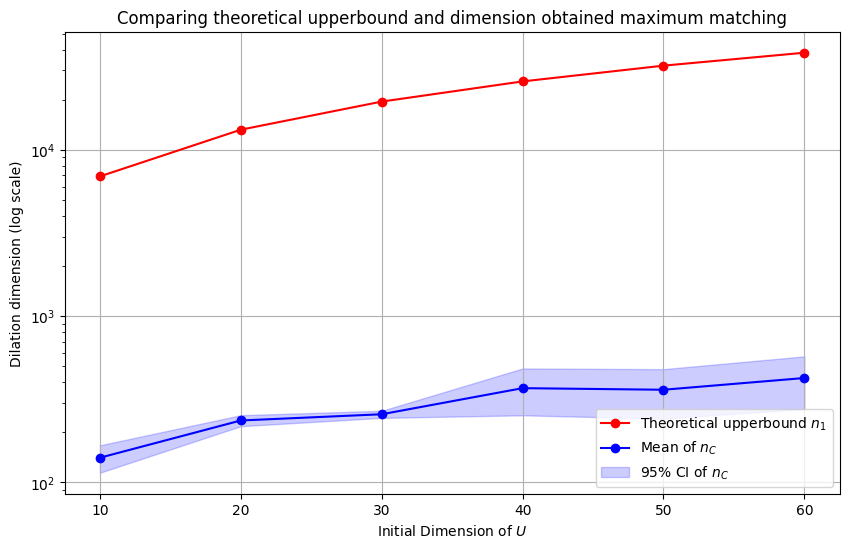

In [35]:
data = np.transpose(Full_n1_list)
time_steps = ndim_list

means = np.mean(data, axis=0)
sem = np.std(data, axis=0) / np.sqrt(data.shape[0])

# time_steps = np.arange(data.shape[1])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps, means, marker='o', linestyle='-', color='r', label='Theoretical upperbound $n_1$')
# plt.fill_between(time_steps, np.maximum(np.zeros_like(means), means - 1.96 * sem), means + 1.96 * sem, color='b', alpha=0.2, label='95% CI')


data = np.transpose(Full_cdim_list)
time_steps = ndim_list

means = np.mean(data, axis=0)
sem = np.std(data, axis=0) / np.sqrt(data.shape[0])

# time_steps = np.arange(data.shape[1])

# Plotting
plt.plot(time_steps, means, marker='o', linestyle='-', color='b', label='Mean of $n_C$')
plt.fill_between(time_steps, np.maximum(np.zeros_like(means), means - 1.96 * sem), means + 1.96 * sem, color='b', alpha=0.2, label='95% CI of $n_C$')


plt.xlabel('Initial Dimension of $U$')
plt.ylabel('Dilation dimension (log scale)')
plt.yscale('log')
plt.title('Comparing theoretical upperbound and dimension obtained maximum matching')
plt.legend(loc = "best")
plt.grid(True)

plt.savefig('./results/MMBPvsUpper.pdf')
plt.show()




In [ ]:
np.pi * 2 * (len(Tu)+1) / np.arccos(1 - (0.01 ** 2) / 2) 